<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC4</p>
<p style="margin: 0; text-align:right;">2020-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 4: Regresión y Combinación de clasificadores

Está práctica está dividida en dos partes:

 - En el primer ejercicio aplicaremos distintos modelos de regresión en diferentes conjuntos de datos.
 - En el segundo ejercicio estudiaremos diferentes técnicas mediante las que podremos combinar el resultado de múltiples clasificadores.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nombre y apellidos:</strong>
</div>

Para esta PEC se deben usar **únicamente las librerías que se importan a continuación**. Si se desea usar otra librería hay que consultarlo con el tutor/tutora del aula.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

%matplotlib inline

# 1. Regresión (5 puntos)

En la primera parte de este ejercicio analizaremos los resultados de distintos modelos de regresión aplicados a tres conjuntos de datos sintéticos con los que veremos sus fortalezas y debilidades.

En la segunda parte aplicarermos el modelo que creamos más oportuno a un problema de la vida real.

## 1.1. Conjuntos de datos sintéticos

Generaremos tres conjuntos de datos con un único atributo descriptivo que utilizaremos para predecir el valor de la variable dependiente, pudiendo así visualizar en dos dimensiones el comportamiento de cada modelo.

Por otro lado, en los problemas de regresión podemos encontrar dos tipos de problemática diferente: **interpolación** (la predicción se realizará en base a atributos descriptivos dentro de un intervalo conocido) y **extrapolación** (alguno de sus atributos descriptivos toma valores fuera del rango de valores visto por el algoritmo durante la etapa de aprendizaje).

Como sólo dispondremos de un atributo descriptivo, pondremos un umbral en dicho atributo para diferenciar lo que sería interpolación (lo marcaremos en azul) de lo que sería extrapolación (en rojo). La gran diferencia entre estos dos subconjuntos de datos es que mientras parte de los datos que interpolaremos los utilizaremos para entrenar, ningún dato de los que extrapolaremos los utilizaremos en la etapa de aprendizaje.

En siguiente código genera y muestra los tres conjuntos de datos:

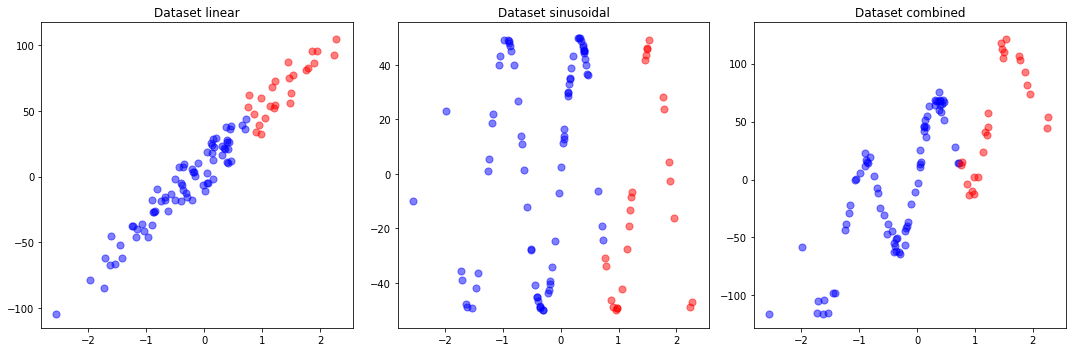

In [2]:
# Cada variable (linear, sinusoidal y combined) será una tupla con cinco posiciones:
# el nombre del dataset y los dos valores X e y tanto para casos de interpolación como de extrapolación.
X, y = datasets.make_regression(n_features=1, n_samples=100, bias=9, noise=9, random_state=0)
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)
data_linear = ('linear', X[:75], y[:75], X[-25:], y[-25:])
X, y = datasets.make_regression(n_features=1, n_samples=100, bias=5, noise=5, random_state=0)
y = (50*np.sin(5*X)).ravel()
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)
data_sinusoidal = ('sinusoidal', X[:75], y[:75], X[-25:], y[-25:])
X, y = datasets.make_regression(n_features=1, n_samples=100, bias=5, noise=5, random_state=0)
y += (50*np.sin(5*X)).ravel()
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)
data_combined = ('combined', X[:75], y[:75], X[-25:], y[-25:])

# Guardamos todos los datasets en una tupla.
datasets_tuple = (data_linear, data_sinusoidal, data_combined)

# Y mostramos su distribución bidimensional
fig, axis = plt.subplots(1, 3, figsize=(15,5))
for dataset, ax in zip(datasets_tuple, axis):
    ax.scatter(dataset[1], dataset[2], alpha=0.5, color='b', s=50, marker='o')
    ax.scatter(dataset[3], dataset[4], alpha=0.5, color='r', s=50, marker='o')
    ax.set_title('Dataset {}'.format(dataset[0]))

plt.tight_layout()

Con el objetivo de mostrar las capacidades de cada una de las técnicas de regresión sobre los tres conjuntos de datos generados, se facilita la siguient función que, dado un modelo, lo entrena para luego mostrar los resultados obtenidos, tanto en los casos de interpolación como de extrapolación.

In [3]:
def plot_regressor_performance(reg):
    fig, axis = plt.subplots(1, 3, figsize=(15,5))
    for dataset, ax in zip(datasets_tuple, axis):
        reg.fit(dataset[1], dataset[2])
        print(f'Dataset {dataset[0]}, '
              f'score interpolation: {reg.score(dataset[1], dataset[2])}, '
              f'score extrapolation: {reg.score(dataset[3], dataset[4])}')

        X_interpolation = np.linspace(
            np.min(dataset[1]), np.mean(np.array([np.max(dataset[1]), np.min(dataset[3])])), 7500
        ).reshape(-1, 1)
        X_extrapolation = np.linspace(
            np.mean(np.array([np.max(dataset[1]), np.min(dataset[3])])), np.max(dataset[3]), 2500
        ).reshape(-1, 1)

        ax.plot(X_interpolation, reg.predict(X_interpolation), color='b', linewidth=3)
        ax.scatter(dataset[1], dataset[2], alpha=0.25, color='b', s=100, marker='o')
        ax.plot(X_extrapolation, reg.predict(X_extrapolation), color='r', linewidth=3)
        ax.scatter(dataset[3], dataset[4], alpha=0.25, s=100, color='r')
        ax.set_title(f'Dataset {dataset[0]}')
    
    plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Con ayuda de la función *plot_regressor_performance* que acabamos de definir, analiza el comportamiento de cada una de las siguientes técnicas:
- regresión lineal
- knn
- svm
- árbol de decisión


<u>Sugerencia</u>: puedes encontrar la documentación de los modelos de regresión que has de utilizar en los siguientes enlaces: 
- LinearRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- KNeighborsRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
- SVR: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
- DecisionTreeRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿cómo se comporta cada modelo de regresión? ¿Qué modelos extrapolan?
</div>

## 1.2 Conjunto de datos real

### Buscando chollos en Taiwán

En este caso práctico utilizaremos un conjunto de datos público de precios de vivienda en Taiwán con el objetivo de encontrar las mejores ofertas del mercado. La descripción completa del conjunto de datos la podemos encontrar en el siguiente enlace: https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

Procedamos a cargar los datos en un DataFrame de pandas para su posterior uso:

In [8]:
dataset = pd.read_excel('Real estate valuation data set.xlsx', engine='openpyxl')

dataset.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


La primera columna ("*No*") es un identificador numérico de la muestra. Las columnas "*Xn ...*" son los distintos atributos descriptivos. Finalmente, la columna "*Y ...*" es el valor objetivo o precio de la vivienda.

Extraemos del *DataFrame* la variable objetivo y los atributos descriptivos que vayamos a utilizar posteriormente en el modelo predictivo:

In [9]:
X = dataset[[
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude'
]]

y = dataset['Y house price of unit area']

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Es el momento de analizar qué pinta tienen los datos, para ello genera los histogramas de cada atributo descriptivo, muestra gráficas que relacionen cada uno de ellos con la variable objetivo.

<u>Sugerencia</u>: también puede resultar útil observar la distribución geoespacial de los precios.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿puedes deducir algo de las gráficas obtenidas?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>

Con el conocimiento adquirido en el apartado 1.1 y teniendo en cuenta las distribuciones de los datos que acabamos de observar, elige la técnica de regresión que creas que mejor se ajusta al problema que queremos resolver.

Divide el conjunto de datos original en train y test y aplica la técnica elegida.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿por qué has elegido esa técnica? ¿Qué tal se comporta?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>

Es el momento de aplicar el modelo que has entrenado con el subconjunto de train para buscar chollos en el subconjunto de test.

<u>Sugerencia</u>: calcula la diferencia entre el valor predicho y el valor real del precio de cada vivienda del subconjunto de test para encontrar las viviendas más interesantes del mercado.
</div>

# 2. Combinación de clasificadores (5 puntos)

En este ejercicio utilizaremos un subconjunto de 5.000 imágenes provenientes del corpus EMNIST, constituido por carácteres y dígitos escritos a mano
. Dicho subconjunto está formado por 1.000 imágenes para cada una de las 5 clases diferentes ("A", "B", "C", "D" y "E").

La primera parte de este ejercicio abordará la combinación de clasificadores en paralelo mediante las tecnicas de **_Bagging_** y **_Boosting_**.

Mientras que la segunda parte pretende mejorar los resultados aplicando tecnicas de combinación secuencial de clasificadores: **_Stacking_** y **_Cascading_**.

Para empezar, vamos a visualizar el dataset. Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones. El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [15]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["A", "B", "C", "D", "E"]

print("Dimensiones del vector de imágenes: {}".format(images.shape))
print("Dimensiones del vector de etiquetas: {}".format(labels.shape))

Dimensiones del vector de imágenes: (5000, 784)
Dimensiones del vector de etiquetas: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

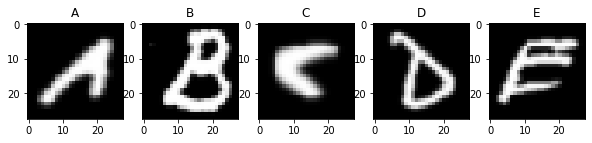

In [16]:
fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28).transpose(), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

Para poder probar varios modelos, primero vamos a dividir el dataset en train y test.

La división con la función *train_test_split* es aleatoria , pero para que todos obtengáis los mismos resultados y poder comentar dudas por el foro, fijaremos la seed para obtener los mismos datasets de train y test. El *split* tendrá en cuenta que los dos conjuntos tengan el mismo número de ejemplos para cada una de las clases gracias al parámetro *stratify=labels*.

Como en la segunda parte de este ejercicio trataremos *stacking* y *cascading*, y ambos se aplican sobre el conjunto de test, haremos un *split* del 50% para tener un poco más de base al aplicar estas dos técnicas.

In [17]:
myseed = 13

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5,
                                                    random_state=myseed, 
                                                    stratify=labels)

## 2.1. Combinación paralela de clasificadores

### 2.1.1. Árbol de decisión

Para poder comparar el aumento de *performance* obtenido a medida que aplicamos técnicas nuevas, utilizaremos como *baseline* un simple árbol de decisión.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Evalúa la precisión de un árbol de decisión con profundidad máxima de 5 niveles (aplicaremos la misma restricción en las siguientes secciones) aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
       
<u>Sugerencia</u>: usar el módulo *cross_val_score* de *sklearn*. Para aprender más sobre *cross validation* y sobre cómo usar estos módulos, os recomendamos los siguientes enlaces: 
- http://scikit-learn.org/stable/modules/cross_validation.html
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

### 2.1.2. *Bagging*

#### 2.1.2.a. Random Forest

La idea básica del bagging es utilizar el conjunto de entrenamiento original para generar centenares o miles de conjuntos similares usando muestreo con reemplazo. En este concepto está basado el algoritmo Random Forest, la combinación de varios árboles de decisión, cada uno entrenado con una realización diferente de los datos. La decisión final del clasificador combinado (el Random Forest) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
        
Evalúa la precisión de un <i>random forest</i> combinando 20 árboles de decisión con profundidad máxima de 5 niveles aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Para aprender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿han mejorado los resultados respecto a un simple árbol de decisión? ¿Era de esperar?
</div>

#### 2.1.2.b. Out-of-bag

Una ventaja del *bagging* usado en el *Random Forest* es que cada uno de los árboles de decisión ha sido entrenado con una combinación diferente de los datos (muestreo con reemplazo), es decir, cada uno de los árboles no ha visto una determinada parte de los datos originales. Esto define una especie de conjunto de test para cada uno de los árboles, llamado *out-of-bag*, que puede ser usado para estimar el error del modelo sin necesidad de usar el conjunto de test real que creamos previamente, ni de usar estrategias de *cross-validation*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
      
Entrena sobre el conjunto de train un modelo de <i>random forest</i>combinando 20 árboles de decisión con profundidad máxima de 5 niveles y muestra la precisión de este modelo en el *out-of-bag*.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Para aprender más sobre *out-of-bag* y sobre como usar este módulo (incluyendo el atributo *oob&#95;score_*), os recomendamos los siguientes enlaces:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿la precisión obtenida en el <i>out-of-bag</i> y con los métodos de validación anteriores son comparables? ¿Era de esperar? 
</div>

#### 2.1.2.c. Número de clasificadores agregados

En los ejercicios anteriores hemos combinado 20 clasificadores simples en nuestro clasificador combinado. ¿Será que la precisión del clasificador combinado aumenta indefinidamente su desempeño si añadimos más clasificadores?

Para responder a esta pregunta vamos a representar una curva de validación. La curva de validación es una representación gráfica del desempeño de un modelo variando uno de sus parámetros. Esto nos permite entender cuál es el impacto de un determinado parámetro en el desempeño de un modelo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>    
    
Entrena varios modelos de <it>Random Forest</it> con un número de árboles cada vez mayor. Para cada modelo, calcula su precisón en el conjunto de test o usando *cross-validation* en el conjunto de entrenamiento. Opcional: representa gráficamente la evolución de la precisión con el número de árboles para ayudarte en el análisis de los resultados.
<br><br>
    
<u>Sugerencia</u>: usar el módulo *validation_curve* de sklearn. Para aprender a usar este módulo os recomendamos los siguientes enlaces:<br>
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html<br>
- http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿incrementa indefinidamente la precisión con el número de árboles combinados o se satura en una precisión límite? ¿Por qué?
</div>

### 2.1.3. *Boosting*

En el sistema de Boosting se combinan varios clasificadores débiles sequencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificados en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>

Evalúa la precisión de un <i>gradient boosting</i> con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i> aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *GradientBoostingClassifier* de sklearn. Para aprender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿han mejorado los resultados respecto a un simple árbol de decisión? ¿Era de esperar?
</div>

## 2.2. Combinación secuencial de clasificadores base diferentes

Para poder hacer combinación secuencial de modelos, necessitamos tener varios modelos diferentes entrenados. 

En nuestro caso, ya tenemos un árbol de decisión, el *random forest* y el *gradient boosting*. Vamos a entrenar un par de modelos más.

### 2.2.1 Clasificadores adicionales

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Entrena un <i>k-neighbors</i> con 2 vecinos sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 

Entrena un SVM (Suport vector machines) con gamma = 0.07 sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 
</div>  

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> comenta los resultados.
</div>

### 2.2.2 *Stacking*

Un clasificador de *stacking* usa como atributos las predicciones hechas por otros clasificadores en lugar de los datos originales de entrada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>stacking</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones hechas en el conjunto de test por los algoritmos: 
    
- árbol de decisión
- random forest
- gradient boosting
- knn
- svm 
 
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test (en este caso no tenemos conjunto de train, con lo cual se hace directamente cross-validation sobre test).

<u>Sugerencia</u>: usar la función column_stack de numpy para juntar todas las predicciones. Dado que las variables que usaremos ahora como predictors son categóricas, es preferible transformarlas en *dummies* (*one-hot-encoding*). Para apender a usar estas funciones os recomendamos los siguientes enlaces:
- https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> ¿has conseguido mejorar la precisión gracias al <i>stacking</i>? Comenta los resultados.
</div>

### 2.2.3. *Cascading*

El caso de *cascading* es parecido al de *stacking* pero utilizando no solamente las predicciones parciales de los clasificadores base, sino también los datos originales.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>cascading</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones obtenidas con los modelos anteriores en el conjunto de test (igual que con el <i>stacking</i>), y también las variables originales. 
    
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test.

<u>Sugerencia</u>: Usa el mismo conjunto de datos que en el ejercicio anterior pero añade `X_test`.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> ¿has conseguido mejorar la precisión gracias al <i>cascading</i>? Comenta los resultados.
</div>